In [1]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
import psutil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import patches

In [2]:
warnings.filterwarnings('ignore')

In [6]:
TRMM_dir = '/data2/willytsai/TRMM_3hr/TRMM/2014_2018'

date = []; date_begin = datetime(2014,1,1)
for t in range(14608):
    tmp = date_begin + t*timedelta(hours=3)
    date.append(tmp)

In [7]:
%%time
# TRMM3B42 dataset 2014, 3hrly separate
yr = ['2014_2018']
prec_3hr = np.nan*np.zeros((len(date),241,1440))

n=1
for y in yr:
    os.chdir(TRMM_dir)
    files = sorted(glob('3B42.*'))
    for file in files:
        data = xr.open_dataset(file).precipitation        
        prec_3hr[n-1,:,:] = data.values.swapaxes(0,1)
        n+=1
lon = data.nlon; lat = data.nlat
prec_xr = xr.DataArray(prec_3hr,coords=[date,lat,lon],dims=['time','lat','lon']); del prec_3hr

CPU times: user 3min 12s, sys: 5min, total: 8min 12s
Wall time: 5min 21s


In [9]:
# load data
os.chdir('/data/willytsai/ISCCP/')

# variable namelist
var_name = np.loadtxt('var_name_2014_2018_5deg_4ds.dat',dtype='U16')
# event time
var_time = np.loadtxt('time_event_2014_2018_5deg_4ds.dat',dtype='U13')
time_event = []
for t in var_time:
    tmp = datetime.strptime(t,'%Y-%m-%d-%H')
    time_event.append(tmp)

var_dataset = (np.loadtxt('var_event_2014_2018_5deg_4ds.dat'))

In [10]:
def event_region(lat_event,lon_event,lon_w,lon_e,lat_s,lat_n):
    'select specfic region'
    idx = np.where(np.logical_and(lon_event >= lon_w, lon_event <= lon_e))[0]
    idy = np.where(np.logical_and(lat_event >= lat_s, lat_event <= lat_n))[0]
    idc = np.intersect1d(idx,idy)
    return idc

In [11]:
lat_event = var_dataset[:,0]
lon_event = var_dataset[:,1]

# select regions
idx = event_region(lat_event,lon_event,70,70,0,0)
time_event = np.asarray(time_event)[idx]
lat_event = lat_event[idx]
lon_event = lon_event[idx]

In [46]:
prec_sm = prec_xr.sel(time=slice(datetime(2015,1,1,0),datetime(2015,6,30,21)),
                      lat=slice(-2.5,2.5),lon=slice(67.5,72.5))
prec_mean = prec_sm.mean(axis=(1,2))

In [47]:
prec_cri = np.ones(len(prec_mean))*5

In [49]:
idx_rec = []
for n in range(len(prec_sm.time)):
    tmp = prec_sm.time[n].values
    for k in time_event:
        if tmp == np.datetime64(k):
            #print(tmp)
            idx_rec.append(n)
idx_rec = np.asarray(idx_rec)

In [112]:
prec_time = []
for n in range(len(prec_sm)):
    test = prec_sm[n].time.values
    tmp = datetime.utcfromtimestamp(test.tolist()/1e9)
    prec_time.append(tmp)
prec_time = np.asarray(prec_time)

In [150]:
len(prec_time)

1448

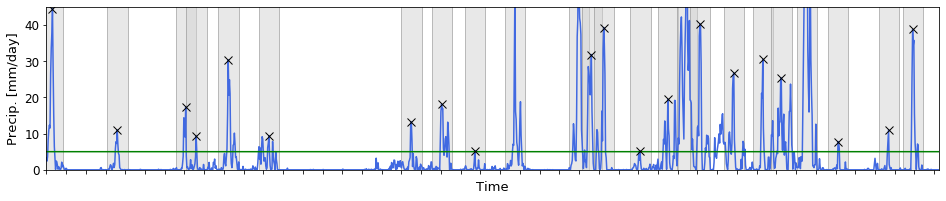

In [165]:
fig,ax = plt.subplots(1,1,figsize=(16,3))

ax.plot(24*prec_mean.values,color='royalblue')
ax.plot(prec_cri,'g')

for n in idx_rec:
    ax.plot(n,24*prec_mean.values[n],'xk',markersize=8)
    rect2 = patches.Rectangle((n-16,0),33,50,linewidth=1,
                              edgecolor='grey',facecolor='lightgrey',alpha=0.5)
    ax.add_patch(rect2)

ax.set_ylim([0,45]);ax.set_xlim([0,len(prec_time)])
ax.set_xticks(np.arange(0,1448,32));ax.set_xticklabels(labels=[])
ax.set_xlabel('Time',fontsize=13)
ax.set_ylabel('Precip. [mm/day]',fontsize=13)
ax.tick_params(labelsize=12)
plt.show()

In [166]:
fig.savefig('/data/willytsai/ISCCP/fig/event_sampling.pdf',bbox_inches='tight')